**Preprocessing**

In [0]:
from bs4 import BeautifulSoup as bs
import pandas as pd

In [0]:
import urllib.request as u
response = u.urlopen("https://patents.google.com/patent/US9033315B2/en")
page_source = response.read()

In [0]:
import csv
import pandas as pd
from pypatent import Patent
file1 = open('/content/data.csv', 'r')
csv_reader = csv.reader(file1)
df = pd.DataFrame()
list3 = []
list2 = []
c = 0
corrupt = 0
for row in csv_reader:
        try:
            for i in range(4):
                data=Patent(title=str(i),url='https://patents.google.com/patent/' + str(row[i]) +'/en')
                label=""
                if(i == 0):
                    label = "Non-Alcohol"
                elif (i == 1):
                    label = "Alcohol"
                elif( i == 2):
                    label = "Non Autonomous"
                elif( i== 3):
                    label = "Autonomous"
                data.fetch_details()
                list2.append(label)
                if(data.abstract != None):
                    if type(data.abstract)!=str:
                        list3.append(data.abstract.join())
                else:
                        if type(data.description)!=str:
                          list3.append(''.join(data.description))
                print(str(c)+' '+str(i))
        except Exception as e:
                print(e)
        c+=1

data.csv  sample_data/


In [0]:
rows_list=[]
for i in range(len(list2)):
  _dict={}
  _dict['label']=list2[i]
  _dict['text']=list3[i]
  rows_list.append(_dict)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.text import *
df = pd.read_csv('data_new_abstract.csv',index_col=None)
df.head()


,Unnamed: 0,label,text
0,0,Non-Alcohol,Methods and compositions for targeted delivery...
1,1,Alcohol,The present invention provides a process for t...
2,2,Non Autonomous,A battery charger is disposed above an exhaust...
3,3,Autonomous,Self-driving vehicles have unlimited potential...
4,4,Non-Alcohol,The present invention provides stabilized oil-...


In [2]:
df

,Unnamed: 0,label,text
0,0,Non-Alcohol,Methods and compositions for targeted delivery...
1,1,Alcohol,The present invention provides a process for t...
2,2,Non Autonomous,A battery charger is disposed above an exhaust...
3,3,Autonomous,Self-driving vehicles have unlimited potential...
4,4,Non-Alcohol,The present invention provides stabilized oil-...
...,...,...,...
1050,1050,Alcohol,Embodiments of the present disclosure are dire...
1051,1051,Non Autonomous,An externally chargeable vehicle which is char...
1052,1052,Non-Alcohol,Disclosed herein is a nutritional composition ...
1053,1053,Alcohol,The present invention relates to a plumbing co...


In [0]:
for i in range(1055):
  f= open(str(df['label'].iloc[i])+'/'+str(i)+".txt","w+")
  f.write(df['text'].iloc[i])
  f.close()

In [7]:
bs=48
data_lm = (TextList.from_folder('/content/')
           #Inputs: all the text files in path
            .filter_by_folder(include=['Alcohol', 'Non-Alcohol', 'Autonomous','Non Autonomous']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.2)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [8]:
data_lm.show_batch()

idx,text
0,"the valid spaces and providing a xxunk xxunk of the valid spaces to the user , wherein the identifying , selecting , ranking and providing steps are performed by a computer system comprising a memory and at least one processor coupled to the memory . xxbos xxmaj the invention provides the automatic opening control system of a kind of vehicle trunk , vehicle and method , wherein system comprises :"
1,the body structure of this xxmaj operation xxmaj van easily can carry out xxmaj fuel xxmaj tank or storage battery etc . relative to the xxunk being formed in the accommodation space taking pedal rear side and xxunk this xxmaj fuel xxmaj tank or storage battery etc . xxmaj the cover of xxunk can be xxunk relative to the lateral outer ends portion of taking pedal : cover the longitudinal
2,to achieve an improved xxunk of the suitable timing of the outputting of the information it is provided that the time between xxunk of the event and outputting of the information is set as a function of the orientation of the driver 's head . xxbos a method includes receiving and storing sensor data including a first plurality of data points indicative of a plurality of respective states of the
3,"( 18 ) has a first communication module ( 22 ) , and a second communication module ( 16 ) is provided for the use module ( 4 ) and for the storage location ( 6 , 8) . xxmaj the recognition interfaces make contact when the use module ( 4 ) is at the storage location ( 6 , 8) . xxmaj if a storage location ( 28 ,"
4,"motor vehicle lamp ( 10 ) comprises multiple organic light emitting diodes ( 1 ) and / or multiple groups of organic light emitting diodes ( 1 ) . xxmaj the light emitting diodes ( 1 ) can be electrically controlled separately from one another and are xxunk arranged . xxmaj the light emitting diodes ( 1 ) emit radiation of the same xxunk composition . xxmaj in addition ,"


In [9]:
data_lm = (TextList.from_csv('/content/', 'data_new_abstract.csv', cols='text')
                   .split_by_rand_pct(0.2)
                   .label_for_lm()
                   .databunch())

In [10]:
data_lm.valid_ds

LabelList (211 items)
x: LMTextList
xxbos xxmaj in order to provide a work vehicle display device , a display method for the same , and a work vehicle that can xxunk to an operation switch a function of xxunk output of a warning even for a display device having a small number of operation switches , provided is a work vehicle display device which includes a display screen of a display unit 31 that xxunk the operation status of the work vehicle and an operation unit 32 that switches the display of the display screen , wherein the work vehicle display device comprises : an xxunk detection unit 33 that detects an xxunk in the work vehicle ; a warning output processing unit 34 that causes a warning to be output in accordance with an xxunk detection state detected by the xxunk detection unit 33 ; and a termination function xxunk unit 35 that xxunk to the operation unit 32 a function for xxunk output of the warning . xxmaj the warning output processing unit 34 performs processing to xxunk ou

**Language Model**

In [0]:
learn = language_model_learner(data_lm,AWD_LSTM, drop_mult=0.2)

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


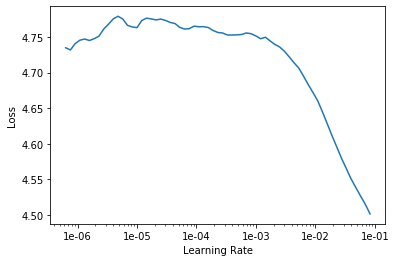

In [13]:
learn.recorder.plot(skip_end=25)

In [0]:
learn.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.635917,4.357613,0.268654,00:05


In [14]:
learn.fit_one_cycle(6, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.551450,3.932312,0.287946,00:03
1,4.086808,3.631257,0.310459,00:03
2,3.635947,3.554216,0.315402,00:03
3,3.259309,3.532988,0.319994,00:03
4,2.964633,3.527498,0.320727,00:03
5,2.754041,3.524242,0.321524,00:03


In [0]:
learn.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.511849,3.611738,0.324043,00:05
1,2.402221,3.616168,0.322577,00:05


In [15]:
learn.save('fit_head')
learn.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (844 items)
x: LMTextList
xxbos xxmaj methods and compositions for xxunk delivery of xxunk are provided . xxmaj the compositions comprise bile - sensitive xxmaj st. thermophilus bacteria modified to release a biotherapeutic agent following bile exposure . xxmaj biotherapeutic agents released by the xxmaj st. thermophilus bacteria disclosed herein include xxup xxunk and xxup xxunk rich peptides . xxmaj methods of the invention comprise administering to a subject a xxmaj st. thermophilus bacterium modified to release a biotherapeutic agent following bile exposure . xxmaj administration of the xxmaj st. thermophilus bacterium xxunk a desired therapeutic response . xxmaj the bacterium may be modified to express and release xxup xxunk or xxup xxunk rich peptides which subsequently inhibit xxunk xxunk or reduce xxunk damage . xxmaj thus , methods of the invention xxunk use in treating or preventing a variety of gastrointestinal disorder

In [0]:
learn.save('fine_tuned_enc')
learn.load('fine_tuned_enc')
learn.save_encoder('fine_tuned_enc')

**Text Classifier**

In [17]:
data = TextClasDataBunch.from_csv('/content/', 'data_new_abstract.csv')
data.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:537: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
772, 1005, 808, 437, 970...
  if getattr(ds, 'warn', False): warn(ds.warn)


text,target
xxbos xxmaj non - xxmaj alcohol,460
xxbos xxmaj non - xxmaj alcohol,817
xxbos xxmaj non - xxmaj alcohol,138
xxbos xxmaj non - xxmaj alcohol,228
xxbos xxmaj non - xxmaj alcohol,96


In [18]:
data_clas = (TextList.from_folder('/content/', vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_rand_pct()
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['Alcohol','Autonomous','Non Autonomous','Non-Alcohol'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [19]:
data_clas = load_data('/content/', 'data_clas.pkl', bs=bs)
data_clas.show_batch()


text,target
"xxbos xxmaj the invention relates to an electrical ribbon conductor ( 40 , 60 , 80 , 100 ) for motor vehicles , comprising a ribbon conductor core ( 42 , 62 , 82 , 102 ) which is composed of electrically conductive ribbon conductor material , and comprising an insulation which xxunk the ribbon conductor core ( 42 , 62 , 82 , 102 ) and is composed of",Non Autonomous
"xxbos xxmaj the invention relates to a facility which has a xxunk facility area and an adjacent clean facility area , xxunk for receiving the xxunk xxunk , and a wall separating the xxunk area from the clean area , the xxunk area including an xxunk door for receiving the xxunk xxunk , pre - processing stations with xxunk for the pre - washing and / or xxunk by a",Autonomous
"xxbos xxmaj an engine support device ( 100 ) , which is provided for supporting an engine arranged in a front - end vehicle structure of a motor vehicle , comprises the following : a first half - shell ( 120 ) comprising a first end section ( 122 ) , a second end section ( 126 ) opposite same and a first lateral cheek section ( 128 ) ,",Non Autonomous
"xxbos xxmaj the invention relates to a method for the controlled application of a liquid to a material xxunk ( 1 ) , in particular for the application of a xxunk liquor to a material xxunk ( 1 ) , wherein the material xxunk ( 1 ) is moved along a running path ( 2 ) , and the direction of the material xxunk ( 1 ) is changed multiple",Alcohol
xxbos xxmaj the invention discloses a gastrodia elata - ganoderma lucidum wine and a preparation method thereof . xxmaj the invention belongs to health tonic wines for human drinking and especially relates to a health tonic wine prepared by using gastrodia elata and ganoderma lucidum extract xxunk as xxunk functional raw materials and a preparation thereof . xxmaj active ingredients of the health tonic wine are prepared from gastrodia elata,Alcohol


In [29]:
data_clas.valid_ds

LabelList (211 items)
x: TextList
xxbos xxmaj an electrical apparatus for automatically xxunk a beverage , which comprises an air processing system takes in xxunk air and xxunk oxygen content to reach as much as 90 % or higher by volume . xxmaj the apparatus further comprises a controller for automatically controlling parameters of the oxygen xxunk process including a time period for delivery of oxygen xxunk air to a beverage , and the time period is predetermined in accordance with one or more characteristics or xxunk of the beverage .,xxbos xxmaj the invention relates to the development of microorganisms capable of producing fermentation products via an engineered xxunk in the microorganisms . xxmaj the invention also relates to microorganisms with improved cell xxunk and methods to improve cell xxunk and cell xxunk of a microorganism .,xxbos a wine barrel rack system having first and second ground level side rails oriented generally parallel to one another , each of the first and se

In [20]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.1)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (844 items)
x: TextList
xxbos xxmaj systems and methods for providing a user with information on xxunk in which to park a vehicle are provided . a method for providing a user with information on xxunk in which to park a vehicle , comprises identifying one or more xxunk in which to park the vehicle , selecting valid xxunk from the identified one or more xxunk based on a xxunk xxunk , and xxunk the valid xxunk and providing a xxunk xxunk of the valid xxunk to the user , wherein the identifying , selecting , xxunk and providing steps are performed by a computer system comprising a memory and at least one processor coupled to the memory .,xxbos xxmaj the invention provides the automatic opening control system of a kind of vehicle trunk , vehicle and method , wherein system comprises : xxunk enter system , xxup can network system , receiving wire , inductive probe , and boot control system ; xxmaj the described system that xxunk enters ca

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


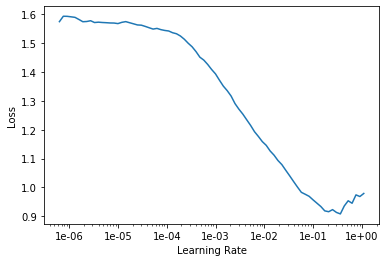

In [22]:
learn.recorder.plot()

In [0]:
learn.freeze_to(-3)

In [0]:
# stopped after 5 iterations with 1e-1 lr, 0.7 momentum acc = 86.3;;;;
#stopped after 1 iteration with 1e-1 lr, 0.7 momentum acc = 87.5
#stopped after 6 iterations with 1e-3 lr, 0.9 momentum acc = 87.5
#stopped after 5 iterations with 1e-3 lr, 0.7 momentum acc = 87.5
#stopped after 3 iterations with 1e-2 lr, 0.7 momentum acc = 88.1
#stopped after 6 iterations with 1e-2 lr, 0.7 momentum acc = 87.5
#stopped after 6 iterations with 1e-1 lr, 0.9 momentum acc = 88.6

In [24]:
learn.fit_one_cycle(100, slice(1e-2/(2.6**4),1e-1), moms=(0.7,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.744292,0.801292,0.810427,00:05
1,0.553595,0.494802,0.867299,00:04
2,0.404642,0.424435,0.838863,00:04
3,0.290085,0.404134,0.848341,00:04
4,0.225843,0.532461,0.838863,00:04
5,0.188216,0.638863,0.853081,00:04
6,0.176554,0.488600,0.848341,00:04
7,0.164653,0.438782,0.886256,00:04
8,0.129503,0.442913,0.890995,00:04


KeyboardInterrupt: ignored

In [0]:
learn.save('final')#90.5

In [0]:
learn.fit_one_cycle(100, slice(1e-2/(2.6**4),1e-2), moms=(0.9,0.9))

epoch,train_loss,valid_loss,accuracy,time
0,0.002334,0.546085,0.875000,00:05
1,0.002262,0.560236,0.880952,00:05
2,0.003382,0.566618,0.880952,00:06
3,0.002809,0.594172,0.863095,00:06
4,0.003237,0.606978,0.869048,00:06
5,0.003520,0.619262,0.880952,00:06
6,0.003368,0.636253,0.880952,00:05
7,0.003041,0.642964,0.880952,00:05
8,0.002963,0.617544,0.886905,00:06
9,0.003545,0.581913,0.898810,00:05


KeyboardInterrupt: ignored

In [0]:
learn.fit_one_cycle(100, slice(1e-2/(2.6**4),1e-2), moms=(0.9,0.9))

epoch,train_loss,valid_loss,accuracy,time
0,0.003704,0.574468,0.898810,00:06
1,0.004257,0.599962,0.892857,00:05
2,0.003940,0.590318,0.892857,00:05


KeyboardInterrupt: ignored

In [0]:
learn.fit_one_cycle(100, slice(1e-2/(2.6**4),1e-3), moms=(0.9,0.9))

epoch,train_loss,valid_loss,accuracy,time
0,0.000927,0.576821,0.892857,00:06
1,0.001398,0.593341,0.892857,00:06
2,0.001588,0.592217,0.880952,00:05
3,0.001245,0.595715,0.886905,00:05


KeyboardInterrupt: ignored

In [0]:
learn.fit_one_cycle(100, slice(1e-2/(2.6**4),1e-3), moms=(0.7,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.004805,0.591111,0.886905,00:05
1,0.004421,0.583605,0.886905,00:05
2,0.004125,0.593193,0.886905,00:05
3,0.004169,0.612267,0.892857,00:05
4,0.003815,0.597226,0.886905,00:06
5,0.003366,0.608094,0.892857,00:05
6,0.003909,0.602928,0.886905,00:05
7,0.003657,0.655739,0.880952,00:06
8,0.004053,0.669686,0.886905,00:05
9,0.004604,0.642592,0.875000,00:06


KeyboardInterrupt: ignored

In [0]:
learn.freeze_to(-3)

In [0]:
learn.fit_one_cycle(100, slice(1e-2/(2.6**4),1e-1), moms=(0.7,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.003347,0.575722,0.875000,00:05
1,0.004509,0.886958,0.857143,00:05
2,0.012392,0.629748,0.875000,00:05
3,0.017751,0.755225,0.851190,00:05
4,0.023324,1.075603,0.827381,00:05
5,0.037769,1.329947,0.815476,00:05
6,0.055512,0.686790,0.869048,00:05


KeyboardInterrupt: ignored

In [0]:
learn.fit_one_cycle(100, slice(1e-2/(2.6**4),1e-3), moms=(0.7,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.005098,0.544753,0.892857,00:05
1,0.009283,0.541683,0.886905,00:05
2,0.008107,0.542142,0.886905,00:05
3,0.009281,0.534959,0.898810,00:06
4,0.008670,0.541485,0.898810,00:05
5,0.009027,0.540149,0.892857,00:05
6,0.009377,0.537426,0.898810,00:06


KeyboardInterrupt: ignored

In [0]:
learn.fit_one_cycle(100, slice(1e-2/(2.6**4),1e-3), moms=(0.9,0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.008593,0.555375,0.898810,00:06
1,0.006752,0.561512,0.892857,00:05
2,0.006893,0.554934,0.898810,00:05
3,0.006828,0.552396,0.892857,00:05
4,0.007347,0.548102,0.898810,00:06
5,0.006634,0.547623,0.886905,00:06
6,0.005880,0.558236,0.892857,00:06
7,0.005295,0.550135,0.898810,00:06
8,0.005484,0.541520,0.904762,00:05


KeyboardInterrupt: ignored

In [0]:
learn.fit_one_cycle(100, slice(1e-2/(2.6**4),1e-3), moms=(0.9,0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.007088,0.535476,0.898810,00:05
1,0.006078,0.536205,0.898810,00:05
2,0.006075,0.541740,0.904762,00:05
3,0.005489,0.538552,0.898810,00:05
4,0.004961,0.534301,0.892857,00:06
5,0.004897,0.541230,0.892857,00:05
6,0.005284,0.546486,0.886905,00:05
7,0.004822,0.539596,0.904762,00:05
8,0.004688,0.536633,0.904762,00:06
9,0.004919,0.543525,0.886905,00:05


KeyboardInterrupt: ignored

In [0]:
learn.fit_one_cycle(100, slice(1e-2/(2.6**4),1e-3), moms=(0.7,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.004196,0.596926,0.880952,00:05
1,0.004702,0.604806,0.880952,00:05


KeyboardInterrupt: ignored

In [26]:
learn.load('final')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (844 items)
x: TextList
xxbos xxmaj systems and methods for providing a user with information on xxunk in which to park a vehicle are provided . a method for providing a user with information on xxunk in which to park a vehicle , comprises identifying one or more xxunk in which to park the vehicle , selecting valid xxunk from the identified one or more xxunk based on a xxunk xxunk , and xxunk the valid xxunk and providing a xxunk xxunk of the valid xxunk to the user , wherein the identifying , selecting , xxunk and providing steps are performed by a computer system comprising a memory and at least one processor coupled to the memory .,xxbos xxmaj the invention provides the automatic opening control system of a kind of vehicle trunk , vehicle and method , wherein system comprises : xxunk enter system , xxup can network system , receiving wire , inductive probe , and boot control system ; xxmaj the described system that xxunk enters ca

**Predictions on the Test Dataset**

In [0]:
from bs4 import BeautifulSoup as bs
import urllib.request as u
response = u.urlopen("https://patents.google.com/patent/US9033315B2/en")
page_source = response.read()
soup=bs(page_source)
# x = (soup.find("meta",{"name":"description"})['content'])
# print(x)

In [0]:
import csv
import pandas as pd
file1 = open('test_file1.csv', 'r')
csv_reader = csv.reader(file1)
df = pd.DataFrame()
list3 = []
list2 = []
dict_ = {}
c = 0
for row in csv_reader:
        try:
          print(row[1])
          response = u.urlopen("https://patents.google.com/patent/" + row[1] + "/en")
          page_source = response.read()
          soup=bs(page_source)
          label=""
          list2.append(row[1])
          x = (soup.find("meta",{"name":"description"})['content'])
          list3.append(x)
          print(c)
          c = c+1
          dict_[row[1]]=x
        except Exception as e:
          print("exce")
          print(e)

US20150093479A1
0
US20150086688A1
1
US20150086675A1
2
US20150086655A1
3
US20150080469A1
4
US20150079269A1
5
US20150079232A1
6
US20150079207A1
7
US20150079157A1
8
US20150073125A1
9
US20150072060A1
10
US20150072045A1
11
US20150071891A1
12
US20150068411A1
13
US20150065587A1
14
US20150064310A1
15
US20150064271A1
16
US20150064162A1
17
EP2859818A1
18
EP2843038A1
19
EP2839747A1
20
EP2839749A1
21
EP2832437A1
22
EP2832235A1
23
EP1915058B1
exce
'NoneType' object is not subscriptable
EP2629629B1
exce
'NoneType' object is not subscriptable
EP2268792B1
exce
'NoneType' object is not subscriptable
EP2413708B1
exce
'NoneType' object is not subscriptable
EP1965663B2
exce
'NoneType' object is not subscriptable
EP1723854B1
exce
'NoneType' object is not subscriptable
EP2530148B1
exce
'NoneType' object is not subscriptable
EP1937091B1
exce
'NoneType' object is not subscriptable
EP2412251B1
exce
'NoneType' object is not subscriptable
EP2279659B1
exce
'NoneType' object is not subscriptable
EP2648546B1
exce
'

In [0]:
y = learn.predict('A system for controlling an autonomous vehicle having cameras for obtaining image data of neighboring vehicles in a proximity of the autonomous vehicle and for identifying physical characteristics of the neighboring vehicles, including makes, models, and trims of neighboring vehicles, colors of the neighboring vehicles, and exposed cargo being carried by the neighboring vehicles. The system maps the identified physical characteristics into predicted potential on-road events in the proximity of the autonomous vehicle, and makes driving decisions based on the predicted potential on-road event')

In [0]:
str(y[0])

'Autonomous'

In [0]:
f = open('./subm.txt','w+')
for key, value in dict_.items():
  y = learn.predict(value)
  f.write(key+','+str(y[0])+'\n')

In [0]:
f.close()

In [31]:
!pip install pypatent

     |████████████████████████████████| 911kB 3.7MB/s 


In [33]:
import csv
import pandas as pd
from pypatent import Patent
file1 = open('/content/validation_set.csv', 'r')
csv_reader = csv.reader(file1)
df = pd.DataFrame()
list3 = []
list2 = []
list1 = []
c = 0
corrupt = 0
for row in csv_reader:
        try:
            for i in range(4):
                data=Patent(title=str(i),url='https://patents.google.com/patent/' + str(row[i]) +'/en')
                label=""
                if(i == 0):
                    label = "Non-Alcohol"
                elif (i == 1):
                    label = "Alcohol"
                elif( i == 2):
                    label = "Non Autonomous"
                elif( i== 3):
                    label = "Autonomous"
                data.fetch_details()
                list2.append(label)
                list1.append(row[i])
                if(data.abstract != None):
                    if type(data.abstract)!=str:
                        list3.append(''.join(data.abstract))
                    else:
                        list3.append(data.abstract)
                else:
                    if(data.description != None):
                        if type(data.description)!=str:
                          list3.append(''.join(data.description))
                        else:
                          list3.append(data.description)
                print(str(c)+' '+str(i))
        except Exception as e:
                print(e)
        c+=1

0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3
3 0
3 1
3 2
3 3
4 0
4 1
4 2
4 3
5 0
5 1
5 2
5 3
6 0
6 1
6 2
6 3
7 0
7 1
7 2
7 3
8 0
8 1
8 2
8 3
9 0
9 1
9 2
9 3
10 0
10 1
10 2
10 3
11 0
11 1
11 2
11 3
12 0
12 1
12 2
12 3
13 0
13 1
13 2
13 3
14 0
14 1
14 2
14 3
15 0
15 1
15 2
15 3
16 0
16 1
16 2
16 3
17 0
17 1
17 2
17 3
18 0
18 1
18 2
18 3
19 0
19 1
19 2
19 3
20 0
20 1
20 2
20 3
21 0
21 1
21 2
21 3
22 0
22 1
22 2
22 3
23 0
23 1
23 2
23 3
24 0
24 1
24 2
24 3
25 0
25 1
25 2
25 3
26 0
26 1
26 2
26 3
27 0
27 1
27 2
27 3
28 0
28 1
28 2
28 3
29 0
29 1
29 2
29 3
30 0
30 1
30 2
30 3
31 0
31 1
31 2
31 3
32 0
32 1
32 2
32 3
33 0
33 1
33 2
33 3
34 0
34 1
34 2
34 3
35 0
35 1
35 2
35 3
36 0
36 1
36 2
36 3
37 0
37 1
37 2
37 3
38 0
38 1
38 2
38 3
39 0
39 1
39 2
39 3
40 0
40 1
40 2
40 3
41 0
41 1
41 2
41 3
42 0
42 1
42 2
42 3
43 0
43 1
43 2
43 3
44 0
44 1
44 2
44 3
45 0
45 1
45 2
45 3
46 0
46 1
46 2
46 3
47 0
47 1
47 2
47 3
48 0
48 1
48 2
48 3
49 0
49 1
49 2
49 3
50 0
50 1
50 2
50 3
51 0
51 1
51 2
51 3


In [0]:
y = learn.predict('Non Autonomous vehicle car truck')

In [45]:
print(y)

(Category Autonomous, tensor(1), tensor([1.1409e-09, 8.1145e-01, 1.5651e-05, 1.8853e-01]))


In [48]:
#f = open('predictions.csv','w+')
cnt =0
for i in range(len(list2)):
  y = learn.predict(list3[i])
  z = list2[i]
  if str(y[0])==z:
    cnt += 1
print(cnt/212)

0.9339622641509434


In [0]:
#f = open('predictions.csv','w+')
df = pd.DataFrame()
cnt =0
for i in range(len(list2)):
  y = learn.predict(list3[i])
  z = list2[i]
  #f.write(list1[i]+','+list3[i]+','+str(y[0])+','+str(y[2])+'\n')
#f.close()

In [0]:
rows_list=[]
for i in range(len(list2)):
  _dict={}
  y = learn.predict(list3[i])
  _dict['patent_number']=list1[i]
  _dict['text']=list3[i]
  _dict['category']=y[0]
  _dict['Alcohol']=y[2][0]
  _dict['Autonomous']=y[2][1]
  _dict['Non-Autonomous']=y[2][2]
  _dict['Non-Alcohol']=y[2][3]
  rows_list.append(_dict)

In [0]:
df = pd.DataFrame(rows_list)

In [64]:
df

,patent_number,text,category,Alcohol,Autonomous,Non-Autonomous,Non-Alcohol
0,US9040302B2,Methods and compositions for targeted delivery...,Alcohol,tensor(0.6138),tensor(0.0002),tensor(0.0002),tensor(0.3858)
1,US9012694B2,The present invention provides a process for t...,Alcohol,tensor(0.9945),tensor(0.0002),tensor(0.0050),tensor(0.0003)
2,US9277674B2,A battery charger is disposed above an exhaust...,Non Autonomous,tensor(7.0941e-06),tensor(1.6856e-06),tensor(0.9994),tensor(0.0006)
3,US9646356B1,Self-driving vehicles have unlimited potential...,Autonomous,tensor(1.2797e-06),tensor(0.9996),tensor(3.7154e-05),tensor(0.0003)
4,US9040109B2,The present invention provides stabilized oil-...,Non-Alcohol,tensor(0.0023),tensor(0.0008),tensor(0.0255),tensor(0.9713)
...,...,...,...,...,...,...,...
207,WO2017002093A1,The invention concerns a method using a robot ...,Autonomous,tensor(0.0121),tensor(0.7912),tensor(0.0546),tensor(0.1421)
208,US8960084B2,A juice extractor with a temperature displayin...,Non-Alcohol,tensor(0.0001),tensor(8.4402e-06),tensor(0.0006),tensor(0.9993)
209,WO2015001243A3,The invention relates to an installation (1) f...,Alcohol,tensor(1.),tensor(5.2205e-10),tensor(6.9326e-09),tensor(7.3496e-13)
210,US9272625B2,An electrical power supply system for powering...,Non Autonomous,tensor(6.7832e-07),tensor(8.7877e-06),tensor(1.0000),tensor(1.5938e-05)


In [0]:
df.to_csv('predictions_validation.csv')